## 1. Model Defnition

In [5]:
import torch
import torch.nn as nn
from utils_ismir import MusdbLoaer
from intermediate_layers import TDC, TDC_sampling
from frameworks import U_Net_Framework

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
musdb_loader = MusdbLoaer(device=device)

def mk_tdc (input_c, output_c, f, i):
    print('intermediate\t at level', i, 'with TDC')
    return TDC(in_channels=input_c, num_layers=5, gr=output_c, kf=3)

def mk_tdc_ds (i, f):
    scale = (1,2) 
    print('downsampling\t at level', i, 'with scale(T, F): ', scale, ', F_scale: ', f, '->', f//scale[-1])
    ds = TDC_sampling(in_channels=24, mode='downsampling')
    return ds, f//2

def mk_tdc_us (i, f, n):
    scale = (1,2) 

    print('upsampling\t at level', i, 'with scale(T, F): ', scale, ', F_scale: ', f, '->', f*scale[-1])
    us =  TDC_sampling(in_channels=24, mode='upsampling')
    return us, f*2


model = U_Net_Framework(
    musdb_loader, est_mode='cac_mapping', internal_channels=24, num_blocks=17, 
    mk_block_f=mk_tdc, mk_ds_f=mk_tdc_ds, mk_us_f=mk_tdc_us
).cuda()

intermediate	 at level 0 with TDC
downsampling	 at level 0 with scale(T, F):  (1, 2) , F_scale:  1024 -> 512
intermediate	 at level 1 with TDC
downsampling	 at level 1 with scale(T, F):  (1, 2) , F_scale:  512 -> 256
intermediate	 at level 2 with TDC
downsampling	 at level 2 with scale(T, F):  (1, 2) , F_scale:  256 -> 128
intermediate	 at level 3 with TDC
downsampling	 at level 3 with scale(T, F):  (1, 2) , F_scale:  128 -> 64
intermediate	 at level 4 with TDC
downsampling	 at level 4 with scale(T, F):  (1, 2) , F_scale:  64 -> 32
intermediate	 at level 5 with TDC
downsampling	 at level 5 with scale(T, F):  (1, 2) , F_scale:  32 -> 16
intermediate	 at level 6 with TDC
downsampling	 at level 6 with scale(T, F):  (1, 2) , F_scale:  16 -> 8
intermediate	 at level 7 with TDC
downsampling	 at level 7 with scale(T, F):  (1, 2) , F_scale:  8 -> 4
intermediate	 at level 7 with TDC
upsampling	 at level 0 with scale(T, F):  (1, 2) , F_scale:  4 -> 8
intermediate	 at level 0 with TDC
upsampling	

In [6]:
print('# params:', sum(p.numel() for p in model.parameters() if p.requires_grad) )

# params: 535924


## 2. Load Pretrained Model

In [7]:
!ls pretrained | grep cac_tdc_17_vocals

cac_tdc_17_vocals_top1.pt
cac_tdc_17_vocals_top2.pt
cac_tdc_17_vocals_top3.pt


In [10]:
pretrained_paths = ['pretrained/cac_tdc_17_vocals_top1.pt',
                    'pretrained/cac_tdc_17_vocals_top2.pt',
                    'pretrained/cac_tdc_17_vocals_top3.pt']

pretrained_params = torch.load(pretrained_paths[0], map_location=device)
model.load_state_dict(pretrained_params)

<All keys matched successfully>

## 3. Evaluation: Musdb18 Benchmark

### 3.1 SDR performance of the pretrained U-Net with 17 TDC blocks

4.294336753188171


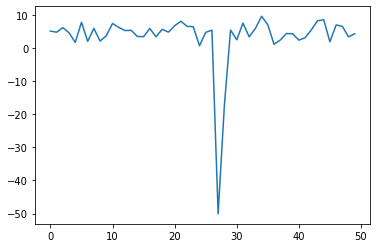

SDR mean: 3.3933820853069205
SDR median: 4.949712322175122
mean of SDR medians:  4.862230856042671


In [11]:
from utils_ismir import separate, eval_testset
import statistics as stats

sdr_medians = []

for pretrained in pretrained_paths:
    
    pretrained_params = torch.load(pretrained, map_location=device)
    model.load_state_dict(pretrained_params)
    
    def separator (mix):
        return separate(musdb_loader, model, mix, batch_size=16)

    sdrs, sdr_mean, sdr_median  = eval_testset(musdb_loader, separator, target_name='vocals')
    sdr_medians.append(sdr_median)
    
print('mean of SDR medians: ', stats.mean(sdr_medians))

### 3.2. SDR performance of the pretrained UMX

In [5]:
# !git clone https://github.com/sigsep/open-unmix-pytorch
# %mv open-unmix-pytorch/test.py open-unmix-pytorch/umx_test.py
# !pip install norbert

6.334033248512589


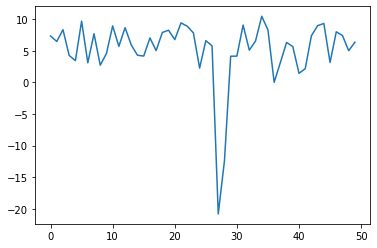

SDR mean: 5.184140683089768
SDR median: 6.319676771911556
UMX's SDR medians:  6.319676771911556


In [22]:
%cd open-unmix-pytorch
import umx_test as umx

musdb_loader = MusdbLoaer(musdb_path='../data/musdb18/', device=device)

def separator(mix):
    
    est = umx.separate(
        audio=mix.T,
        targets=['vocals', 'drums', 'bass', 'other'], 
        device=device
    )
    
    return est['vocals'].T

umx_sdrs, umx_sdr_mean, umx_sdr_median  = eval_testset(musdb_loader, separator, target_name='vocals')

    
print('UMX\'s SDR medians: ', umx_sdr_median)

In [13]:
print('# params:', sum(p.numel() for p in umx.load_model('vocals', ).parameters() if p.requires_grad) )

# params: 8893348
